# Spark - Exploratory Data Analysis

In this courselet, we will explore the use of Spark as a Data Science tool when working with Big Data. By the end of this courselet, you would be able to:

- Perform a descriptive analysis
- Compare the performance of Spark under different data formats (csv vs. parquet)
- Identify the advantages of using Spark in a cluster, by setting up dirrent working instances.

## What is Spark?

[Apache Spark](https://spark.apache.org/) is an open-source engine used for the processing and analysis of large-scale data. Today, Spark is one of the most popular frameworks for the developement of data engineering, data science and machine learning tasks.

## Advantages of Spark

- Multi-language: It can be implemented through multiple-languages (Python, R, Java, Scala), making it flexible for diverse users
- Speed: Spark leverages on RAM to perform it's computational tasks, which translates into faster data processing
- Parallelism and fault tolerance: Spark is designed to be used in the context of a multi-node cluster. Therefore, its design aims for a parallel data processing across nodes, as well as fault tolerance in the case that one of the nodes presents a failure.
- Wide community of users: Given it's popularity, there is a huge open-source community which allows Spark to be constantly developed and improved

## Disadvantages of Spark

- Hardware consumption: The use of RAM to optimize speed also transalates into a higher memory consumption.
- Manual fine-tuning and optimization: To optimize the overall performance of Spark, the user must [tune the settings](https://www.databricks.com/glossary/spark-tuning) of the cluster in terms of hardware. This process is not straightforward
- Unneficient management of small files: For cases of small files, you might want to choose Pandas instead of Spark

## Importing libraries and starting our Spark session.

To start working, we are first going to import our main library and start our spark session.

In [1]:
import pyspark

# Starting a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("EDA").getOrCreate()

# Creating the Spark Context
sc = spark.sparkContext

## RDD

The [Resilient Distributed Dataset (RDD)](https://spark.apache.org/docs/latest/rdd-programming-guide.html) is the main data structure in Spark. It consist of a collection of object distributed across the nodes of the cluster. This allows for the processes to be parallelized across the nodes, an to guarantee fault tolerance. RDD's posses two fundamental types of operations: **transformations**,  which are operations that convert RDD's into new RDD's, and **actions**, which return non-RDD values/objects.

Let's now work with an example RDD.

In [2]:
# We start by creating a list of values
lst = [i for i in range(15)]
# Executing the function "parallelize", converts our list into an RDD
rdd = sc.parallelize(lst)
rdd 

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

In [3]:
# Performing a transformation. 
squared_rdd = rdd.map(lambda x: x**2) # Transforming our RDD into a new one with the same values squared
squared_rdd = squared_rdd.collect() # Collecting our RDD into a list again
squared_rdd # Now we have a list of squared values

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196]

In [4]:
filtered_rdd = rdd.filter(lambda x: x % 2 == 0) # Filtering our RDD into a new one with even numbers
filtered_rdd.count() # Returning the count of even numbers

8

In [5]:
import spacy
en = spacy.load("en_core_web_lg")
stopwords = en.Defaults.stop_words
print(stopwords)

{'though', 'put', 'might', 'must', 'done', 'hundred', 'under', 'amount', 'than', 'the', 'yet', 'bottom', 'something', 'into', 'top', "'s", "'ve", 'hereupon', 'from', 'three', 'twenty', 'two', 'much', 'name', 'can', 'elsewhere', 'everywhere', 'part', 'now', 'is', 'be', 'nothing', 'third', 'hence', 'what', 'unless', 'some', 'him', 'take', 'yours', 'been', 'a', 'except', 'besides', 'over', 'with', 'off', 'say', 'mine', 'seeming', 'whole', 'they', 'anything', 'by', 'everyone', 'thus', 'and', 'up', 'within', 'thru', 'towards', 'serious', 'n’t', 'since', 'become', 'too', 'any', 'here', 'them', 'fifteen', 'call', 'am', 'sometimes', 'either', 'formerly', 'which', 'whom', 'out', 'did', 'fifty', 'their', 'nine', 'ever', 'alone', 'seemed', 'although', 'was', 'back', '’ll', 'due', 'further', 'made', 'front', 'hereafter', '’d', 'would', 'often', 'this', 'such', '’re', 'therein', 'why', 'across', 'most', 'get', 'could', 're', 'whatever', 'mostly', 'against', 'have', 'for', 'his', 'whither', 'somehow

In [6]:
shakespeare = spark.read.text("data/shakespeare.txt")
top_words = (
    shakespeare
    .rdd.flatMap(lambda line: line[0].split(" "))
    .filter(lambda word: word.lower() not in stopwords and word != "")
    .map(lambda word: (word, 1))
    .reduceByKey(lambda x, y: x + y)
    .sortBy(lambda x: x[1], ascending=False)
    .take(10)
)

top_words

[('thou', 4247),
 ('thy', 3630),
 ('shall', 3016),
 ('good', 2046),
 ('Enter', 1926),
 ('thee', 1780),
 ("I'll", 1737),
 ('hath', 1614),
 ('like', 1453),
 ('you,', 1428)]

## Dataframes

For this courselet, we are exploring the taxi trips reported to the City of Chicago in 2020. This data is publicly available through the [Chicago Data Portal](https://data.cityofchicago.org/en/Transportation/Taxi-Trips-2020/r2u4-wwk3/about_data). 

We will proceed to load our data.

In [7]:
df = spark.read.csv("data/chicago-taxi-2020.csv",header=True, inferSchema=True)

As the our first actions, we can print the Schema of the data, and count the number of rows.

In [8]:
df.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [9]:
df.count()

3889032

In [10]:
df[['Trip ID', 'Trip Total']].show(10)

+--------------------+----------+
|             Trip ID|Trip Total|
+--------------------+----------+
|16c7456d99031528c...|     12.27|
|472eef1d5c7a5e5ee...|      13.0|
|031a4d882fb3315a4...|      14.8|
|3c416c246829dfb3f...|      9.75|
|3c0a22971ae070ce3...|      6.75|
|451beabd5dd8ffc54...|     12.25|
|60da9b02b3297dc58...|      21.6|
|64bd098989d7ad38a...|      12.0|
|8e2fa4ad2d00c7372...|     25.25|
|9323dfcf3aa6b0e8c...|      7.75|
+--------------------+----------+
only showing top 10 rows



# Descriptive Statistics

To support our operations, we are going to use the collections of functions provided by pyspark.sql. You can consult the full list in the [source documentation.](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.max.html)

In [11]:
import pyspark.sql.functions as F

In [12]:
# Mean of a column
df.select(F.mean("Trip Total"))

DataFrame[avg(Trip Total): double]

As you can observe, our previous line of code has not returned the mean yet. Instead, it returned a DataFrame object. We must perform an action to display the mean. The following line of code extends the previous one with the extension of the *show.()* action.

In [13]:
df.select(F.mean("Trip Total")).show()

+-----------------+
|  avg(Trip Total)|
+-----------------+
|18.36848553758293|
+-----------------+



In [14]:
# Mean of multiple columns
df.select(F.mean("Trip Total"), F.mean("Trip Seconds")).show()

+-----------------+-----------------+
|  avg(Trip Total)|avg(Trip Seconds)|
+-----------------+-----------------+
|18.36848553758293|874.7527292080763|
+-----------------+-----------------+



In [15]:
# Max value of a column
df.select(F.max("Trip Total")).show()

+---------------+
|max(Trip Total)|
+---------------+
|        9955.55|
+---------------+



In [16]:
df.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total")
    .alias("AVG Trip Total")) \
    .na.drop(subset=["Pickup Community Area"]) \
    .orderBy(F.col("Pickup Community Area")).show()

+---------------------+------------------+
|Pickup Community Area|    AVG Trip Total|
+---------------------+------------------+
|                    1|14.904347051776057|
|                    2|14.709523427124191|
|                    3|13.594861907566413|
|                    4|13.487912290478846|
|                    5| 13.49866142339425|
|                    6|13.551174231054807|
|                    7|13.730048243649621|
|                    8|12.739438021830187|
|                    9| 19.90771171171171|
|                   10|19.228908232118755|
|                   11|15.682493122165218|
|                   12|20.352792553191488|
|                   13|14.851200775475583|
|                   14|15.245882238505931|
|                   15|14.950861089792784|
|                   16|14.187686900245481|
|                   17|19.169364141765115|
|                   18| 19.99314049586777|
|                   19| 16.65431488275642|
|                   20| 18.53338563956253|
+----------

## CSV vs Parquet

So far, we have returned some simple results using the data in csv format. 

In [17]:
df_parquet = spark.read.parquet("data/chicago-taxi-2020.parquet",header=True, inferSchema=True)
df_parquet.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: double (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: double (nullable = true)
 |-- Dropoff Census Tract: double (nullable = true)
 |-- Pickup Community Area: double (nullable = true)
 |-- Dropoff Community Area: double (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid

In [18]:
import time

# CSV Performance
start_csv = time.time()
df.select(F.mean("Trip Total"), F.mean("Trip Seconds")).show()
end_csv = time.time()
total_csv = end_csv - start_csv
print(f"Execution Time (CSV): {total_csv}")

# Parquet Performance
start_parquet = time.time()
df_parquet.select(F.mean("Trip Total"), F.mean("Trip Seconds")).show()
end_parquet = time.time()
total_parquet = end_parquet - start_parquet
print(f"Execution Time (CSV): {total_parquet}")

+-----------------+-----------------+
|  avg(Trip Total)|avg(Trip Seconds)|
+-----------------+-----------------+
|18.36848553758293|874.7527292080763|
+-----------------+-----------------+

Execution Time (CSV): 3.0115723609924316
+-----------------+-----------------+
|  avg(Trip Total)|avg(Trip Seconds)|
+-----------------+-----------------+
|18.36848553758443|874.7527292080763|
+-----------------+-----------------+

Execution Time (CSV): 1.0939338207244873


As we see, in this first example, using a parquet format resulted in a faster performance, providing the same results. Let's look at a second example.

In [19]:
# CSV Performance
start_csv = time.time()
df.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .orderBy(F.col('Pickup Community Area')).show()
end_csv = time.time()
total_csv = end_csv - start_csv
print(f"Execution Time (CSV): {total_csv}")

# Parquet Performance
start_parquet = time.time()
df_parquet.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .orderBy(F.col('Pickup Community Area')).show()
end_parquet = time.time()
total_parquet = end_parquet - start_parquet
print(f"Execution Time (Parquet): {total_parquet}")

+---------------------+------------------+
|Pickup Community Area|    AVG Trip Total|
+---------------------+------------------+
|                 NULL|23.249158787018228|
|                    1|14.904347051776057|
|                    2|14.709523427124191|
|                    3|13.594861907566413|
|                    4|13.487912290478846|
|                    5| 13.49866142339425|
|                    6|13.551174231054807|
|                    7|13.730048243649621|
|                    8|12.739438021830187|
|                    9| 19.90771171171171|
|                   10|19.228908232118755|
|                   11|15.682493122165218|
|                   12|20.352792553191488|
|                   13|14.851200775475583|
|                   14|15.245882238505931|
|                   15|14.950861089792784|
|                   16|14.187686900245481|
|                   17|19.169364141765115|
|                   18| 19.99314049586777|
|                   19| 16.65431488275642|
+----------

# Spark SQL

One of the main features in Spark is the incorporation of an SQL module which allows us to analyze strcutured data through the use of SQL Queries. Let's take a look at some examples.

In [20]:
df_parquet.createOrReplaceTempView("trips") #We create this temporary view so Spark recognizes our dataframe as a table when writing queries.

In [21]:
# Select the Taxi ID that charged the most expensive trip
spark.sql("""
    SELECT `Taxi ID`
    FROM trips
    WHERE `Trip Total` = (SELECT MAX(`Trip Total`) FROM trips)""").show()

+--------------------+
|             Taxi ID|
+--------------------+
|687e3ef9daf087b79...|
+--------------------+



In [22]:
# Select the 5 companies with the highest avg fares
spark.sql("""
    SELECT company, AVG(Fare) as avg_fare
    FROM trips
    GROUP BY Company
    ORDER BY avg_fare DESC
    LIMIT 5
""").show()

+--------------------+------------------+
|             company|          avg_fare|
+--------------------+------------------+
|    Metro Jet Taxi A|294.17248631929584|
|     Chicago Taxicab| 59.78360585544377|
|Suburban Dispatch...|38.412117919486995|
|4053 - 40193 Adwa...| 27.02038626609442|
|4623 - 27290 Jay Kim|26.991394148020653|
+--------------------+------------------+



## Visualizing Data


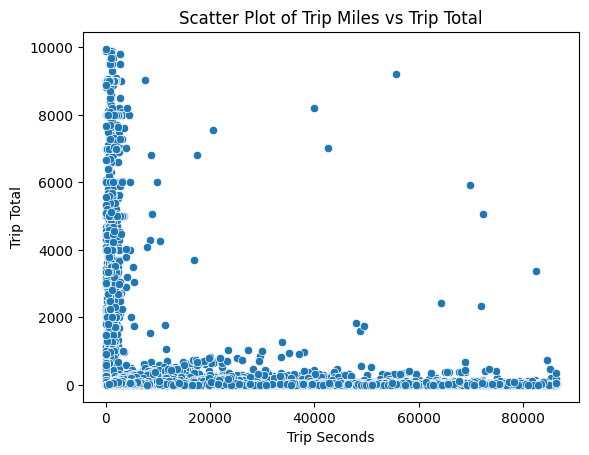

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

trip_seconds = df_parquet.select('Trip Seconds').rdd.flatMap(lambda x: x).collect()
trip_total = df_parquet.select('Trip Total').rdd.flatMap(lambda x: x).collect()

sns.scatterplot(x=trip_seconds, y=trip_total)
plt.title('Scatter Plot of Trip Miles vs Trip Total')
plt.xlabel('Trip Seconds')
plt.ylabel('Trip Total')
plt.show()

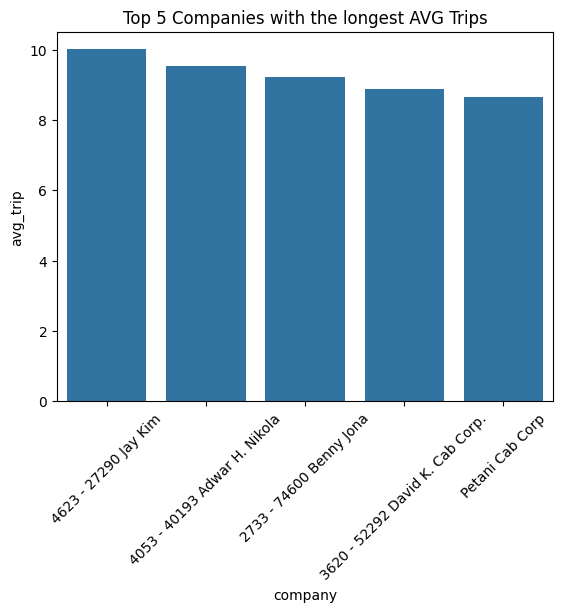

In [24]:
pandas_df = spark.sql("""
    SELECT company, AVG(`Trip Miles`) as avg_trip
    FROM trips
    GROUP BY Company
    ORDER BY avg_trip DESC
    LIMIT 5
""").toPandas() 

sns.barplot(x='company', y='avg_trip', data=pandas_df)
plt.title('Top 5 Companies with the longest AVG Trips')
plt.xticks(rotation=45)
plt.show()

## Fine Tuning

To take the most advantage of Spark, it is important to understand and determine the right configuration in our cluster, so we can improve our performance. 

In [25]:
num_cores = [1,2,4]
for i in num_cores:
    conf = SparkConf().setAppName("PerformanceComparison").setMaster("local[*]").set("spark.executor.instances", i) \
    .set("spark.cores.max", str(i))
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    print(f"Running with {i} cores")
    df = spark.read.csv("data/chicago-taxi-2020.csv",header=True, inferSchema=True)
    df = df.repartition(i)
    start = time.time()
    df.groupBy("Pickup Community Area") \
    .agg(F.avg("Trip Total") \
    .alias("AVG Trip Total")) \
    .orderBy(F.col('Pickup Community Area')).show()
    end = time.time()
    print(f"Execution time: {end-start}\n")

NameError: name 'SparkConf' is not defined